Test_times 0


c:\Users\EE720A\anaconda3\envs\ppotran0517\lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


Current path: [5, 10, 11, 12, 13, 18, 23, 24, 23, 18, 19, 14, 19, 18, 17, 22, 17, 18, 13, 12, 11, 10, 15, 20, 21, 20, 15, 16, 15, 10, 5, 6, 1, 0, 1, 2, 3, 4, 9, 14, 13, 8, 3, 8, 9, 4, 3, 2, 7, 6, 7, 12, 7, 6, 5]
最佳路徑: [0, 1, 6, 1, 2, 7, 12, 7, 6, 5, 10, 15, 16, 15, 20, 21, 20, 15, 10, 11, 12, 13, 18, 23, 24, 23, 18, 17, 22, 17, 18, 19, 14, 9, 14, 13, 8, 3, 8, 9, 4, 3, 2, 1, 0]
最佳長度: 440.0
Episode distance: 542.0
close
Test_times 1
Current path: [22, 23, 24, 19, 14, 19, 18, 23, 18, 13, 18, 17, 18, 23, 22, 21, 20, 15, 10, 11, 6, 5, 0, 1, 2, 7, 2, 3, 4, 3, 8, 9, 14, 9, 8, 13, 8, 7, 6, 11, 16, 21, 16, 11, 12, 11, 16, 21, 22]
最佳路徑: [0, 5, 6, 11, 12, 11, 6, 7, 2, 7, 8, 13, 18, 19, 18, 17, 18, 23, 22, 21, 20, 15, 10, 11, 16, 21, 22, 23, 24, 19, 14, 9, 8, 3, 4, 3, 2, 1, 0]
最佳長度: 380.0
Episode distance: 489.0
close
Test_times 2
Current path: [21, 22, 23, 24, 19, 14, 19, 18, 13, 18, 23, 18, 17, 22, 21, 16, 21, 20, 15, 10, 15, 20, 21, 16, 17, 12, 7, 2, 1, 0, 5, 0, 1, 2, 3, 4, 9, 8, 3, 2, 7, 12, 1

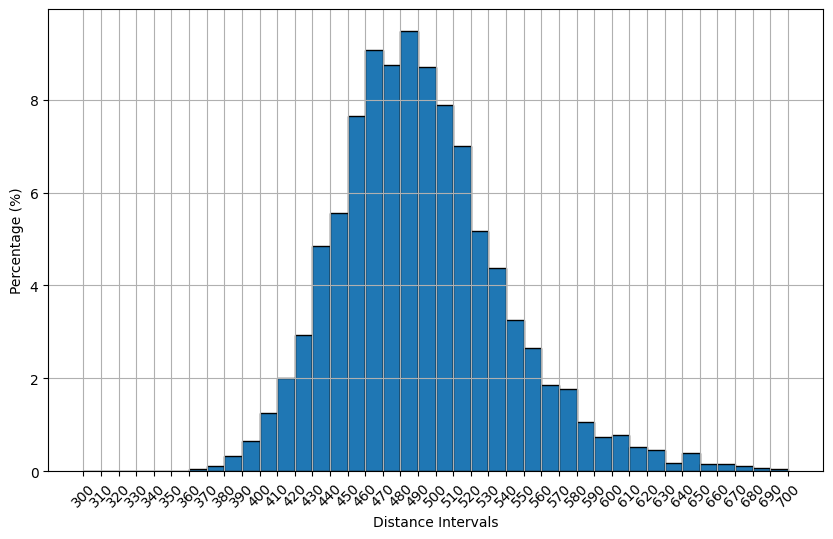

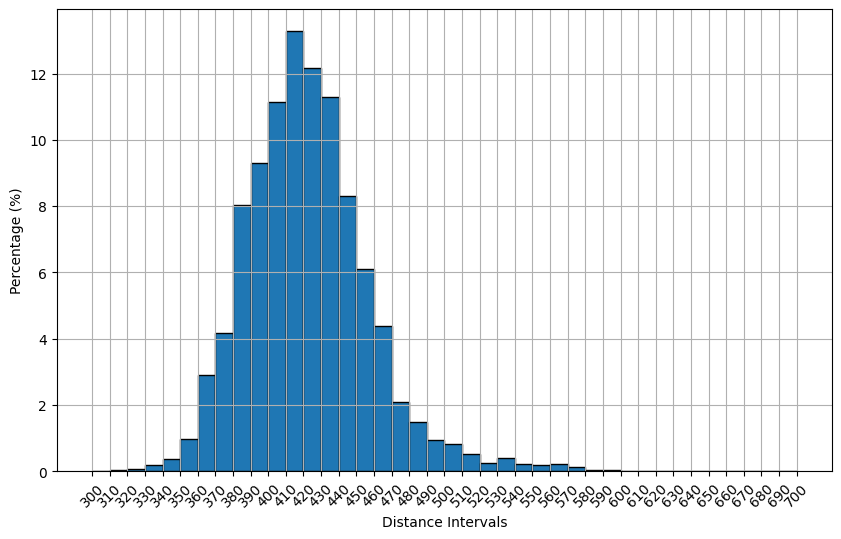

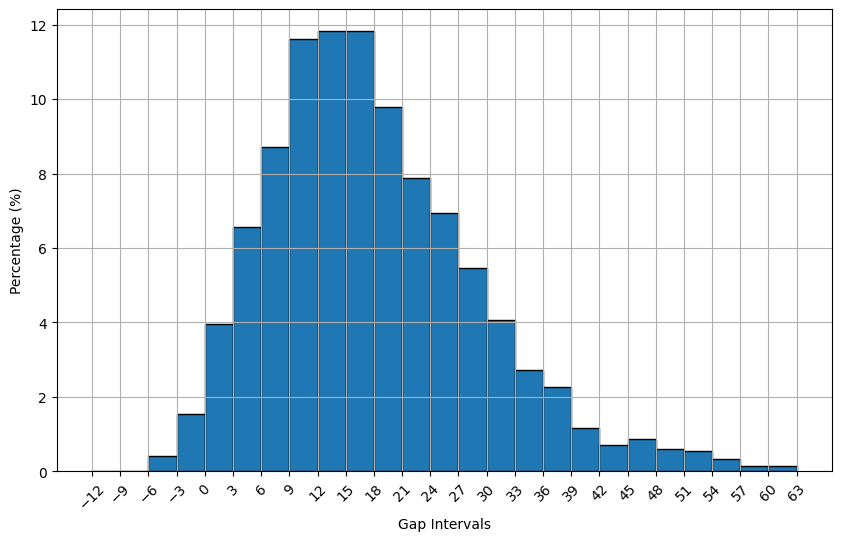

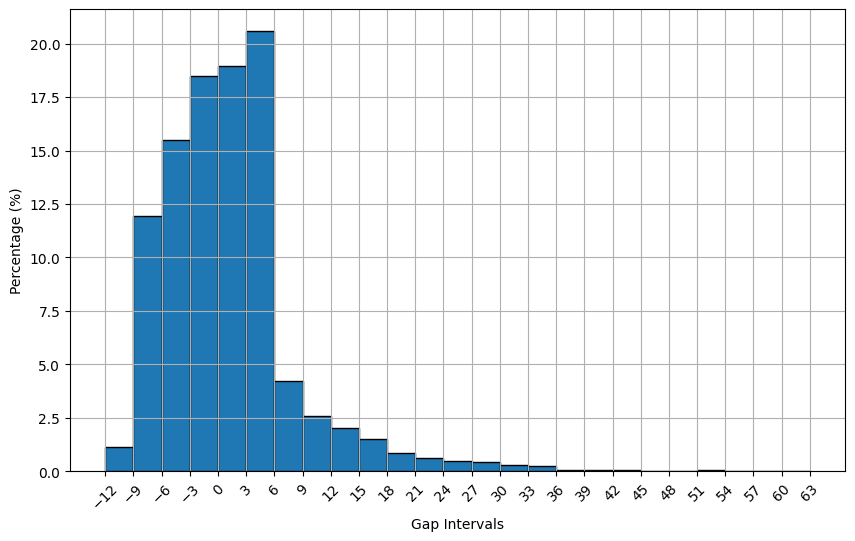

Average Distance and Gap: 491.5565 17.961817185693906 %
Average Adjusted Distance and Gap: 421.84325 1.153629295249235 %
accAverage Distance and Gap 417.165


In [1]:
import numpy as np
import pickle
import torch
import tkinter as tk
from cpp import generate_gif_from_path
from tkinter import filedialog
from docopt import docopt
from model import ActorCriticModel
from utils import create_env
import time
from datetime import datetime
import matplotlib.pyplot as plt
import edmonds_best_solution

def count_intervals_and_plot(results, start=300, end=700, step=10,xlbe = 'Distance Intervals'):
    # Create an array to represent the bins
    bins = np.arange(start, end + step, step)
    
    # Use numpy's histogram function to count occurrences in each bin
    counts, edges = np.histogram(results, bins=bins)
    
    # Convert counts to percentages
    total_counts = sum(counts)
    percentages = (counts / total_counts) * 100  # Convert to percentage

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(edges[:-1], percentages, width=np.diff(edges), edgecolor="black", align="edge")
    plt.xlabel(xlbe)
    plt.ylabel('Percentage (%)')
    # plt.title('Distribution of Scores as Percentages')
    plt.xticks(edges, rotation=45)
    plt.grid(True)
    plt.show()
    
    return counts, edges


def init_transformer_memory(trxl_conf, max_episode_steps, device):
    """Returns initial tensors for the episodic memory of the transformer.

    Arguments:
        trxl_conf {dict} -- Transformer configuration dictionary
        max_episode_steps {int} -- Maximum number of steps per episode
        device {torch.device} -- Target device for the tensors

    Returns:
        memory {torch.Tensor}, memory_mask {torch.Tensor}, memory_indices {torch.Tensor} -- Initial episodic memory, episodic memory mask, and sliding memory window indices
    """
    # Episodic memory mask used in attention
    memory_mask = torch.tril(torch.ones((trxl_conf["memory_length"], trxl_conf["memory_length"])), diagonal=-1)
    # Episdic memory tensor
    memory = torch.zeros((1, max_episode_steps, trxl_conf["num_blocks"], trxl_conf["embed_dim"])).to(device)
    # Setup sliding memory window indices
    repetitions = torch.repeat_interleave(torch.arange(0, trxl_conf["memory_length"]).unsqueeze(0), trxl_conf["memory_length"] - 1, dim = 0).long()
    memory_indices = torch.stack([torch.arange(i, i + trxl_conf["memory_length"]) for i in range(max_episode_steps - trxl_conf["memory_length"] + 1)]).long()
    memory_indices = torch.cat((repetitions, memory_indices))
    return memory, memory_mask, memory_indices
def load_model_path(default = False):
    root = tk.Tk()
    if default:
        return f"models/20240420-232428/2.391.nn "
    else:
        #default folder is model
        file_path = filedialog.askopenfilename(initialdir = "models")
        root.destroy()
        return file_path

def main(model,times):
    # Command line arguments via docopt
    _USAGE = """
    Usage:
        enjoy.py [options]
        enjoy.py --help
    
    Options:
        --model=<path>              Specifies the path to the trained model [default: ./models/run.nn].
    """
    # options = docopt(_USAGE)
    # model_path = options["--model"]
    # model_path = load_model_path()   
    # Set inference device and default tensor type
    device = torch.device("cpu")
    torch.set_default_tensor_type("torch.FloatTensor")

    # Load model and config
    state_dict, config = pickle.load(open(model_path, "rb"))

    # Instantiate environment
    env = create_env(config["environment"], render=True)

    # Initialize model and load its parameters
    model = ActorCriticModel(config, env.observation_space, (env.action_space.n,), env.max_episode_steps)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    # Run and render episode
    done = False
    episode_rewards = []
    memory, memory_mask, memory_indices = init_transformer_memory(config["transformer"], env.max_episode_steps, device)
    memory_length = config["transformer"]["memory_length"]
    t = 0
    obs = env.reset()
    # G = env.create_networkx_graph()
    # NUM_NODES = env.num_nodes
    # Side = int(NUM_NODES**0.5)
    # pos = {i: (i % Side, Side - 1 - i // Side) for i in range(NUM_NODES)}
    # env.plot_graph(G,  pos, "test2.png")
    start_time = time.time()
    while not done:
        # Prepare observation and memory
        obs = torch.tensor(np.expand_dims(obs, 0), dtype=torch.float32, device=device)
        in_memory = memory[0, memory_indices[t].unsqueeze(0)]
        t_ = max(0, min(t, memory_length - 1))
        mask = memory_mask[t_].unsqueeze(0)
        indices = memory_indices[t].unsqueeze(0)
        # Render environment
        # env.render()
        # Forward model
        policy, value, new_memory = model(obs, in_memory, mask, indices) #in_memory ([1, 64, 3, 512]) #indices 64
        # print(in_memory[0][0][0])#
        memory[:, t] = new_memory
        # Sample action
        action = []
        for action_branch in policy:
            action.append(action_branch.probs.argmax().item())
        # Step environemnt
        # print("next step is to go to ",int(action[0]))
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        t += 1
    
    # after done, render last state
    env.render()
    end_time = time.time()
    # elapsed_time = end_time - start_time
    # print("Result is ",env.ok)
    # print(f"函數執行耗時：{elapsed_time} 秒")   
    trad_len = edmonds_best_solution.resolution(env.map)
    print("Episode distance: " + str(info["distance"]))
    # print("Episode length: " + str(info["length"]))
    # print("Episode reward: " + str(info["reward"]))
    euler_path = env.path
    euler_path = [(str(euler_path[i]), str(euler_path[i + 1])) for i in range(len(euler_path) - 1)]
    repeat_path = euler_path
    # if info["distance"] < 400:
    #     generate_gif_from_path(env.create_networkx_graph() , env.get_pos(), euler_path, repeat_path, 1, int(info["distance"]))

    
    env.close()
    return env.ok, info, trad_len

if __name__ == "__main__":
    model_path = load_model_path() 
    total_reward = 0
    total_length = 0
    done_length = 0
    total_dinstance = 0
    ad_total_dinstance = 0
    acc_total_distance = 0
    Test_times = 4000
    done = 0
    distances = []
    adjusted_distance = []
    gap = []
    adjusted_gap = []
    numbers = [60, 80, 100]
    probabilities = [0.25, 0.5, 0.25]
    for i in range(Test_times):
        print("Test_times",i)
        test, info, tranlen = main(model_path,i)
        done = test + done
        total_reward += info["reward"]
        # total_length += info["length"]
        total_dinstance += info["distance"]
        if test == 1:
            done_length += info["length"]
        # print("Succesful: ", done/(i+1)*100,"%")
        # print("tranlen",tranlen)
        # print("intfo",info["distance"])
        distances.append(info["distance"])
        gap.append((info["distance"]-tranlen)/tranlen*100)
        acc_total_distance += tranlen
        if info["distance"] > tranlen:
            temp = max((info["distance"]- np.random.choice(range(85,120))),tranlen-np.random.choice(range(-25,40)))
        else:
            temp = info["distance"]
        adjusted_gap.append((temp-tranlen)/tranlen*100)
        ad_total_dinstance += temp
        adjusted_distance.append(temp)
    average_reward = total_reward / Test_times   
    average_length = total_length / Test_times  
    average_distance = total_dinstance / Test_times
    average_succ = done/Test_times
    average_succ = done/Test_times
    average_done_length = done_length/done
    acc_total_distance = acc_total_distance/Test_times
    count_intervals_and_plot(distances, start=300, end=700, step=10, xlbe = 'Distance Intervals')
    count_intervals_and_plot(adjusted_distance,end=700)
    count_intervals_and_plot(gap, start=-12, end=63, step=3, xlbe='Gap Intervals')
    count_intervals_and_plot(adjusted_gap, start=-12, end=63, step=3, xlbe='Gap Intervals')
    print("Average Distance and Gap:", average_distance, sum(gap)/Test_times, "%")
    print("Average Adjusted Distance and Gap:", ad_total_dinstance / Test_times, sum(adjusted_gap)/Test_times, "%")
    print("accAverage Distance and Gap", acc_total_distance)

    # print("Average Reward:", average_reward)
    # print("Average Length:", average_length)
    # print("Average Distance:", average_distance)
    # print("Average Adjusted Distance:", ad_total_dinstance / Test_times)
    # print("Average Done Length:", average_done_length)
    # print("Succesful: ", average_succ*100,"%")


